In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
import warnings
from sklearn.impute import SimpleImputer

warnings.filterwarnings("ignore")

In [16]:
# ============================
# 1. Define File Paths
# ============================
meteo_files = {
    'location0': r"C:\Users\USER\Desktop\job applying\openmeteo_location0.csv",
    'location1': r"C:\Users\USER\Desktop\job applying\openmeteo_location1.csv",
    'location2': r"C:\Users\USER\Desktop\job applying\openmeteo_location2.csv",
    'location3': r"C:\Users\USER\Desktop\job applying\openmeteo_location3.csv"
}
market_file = r"C:\Users\USER\Desktop\job applying\spot_balancing_2025Q1.csv"

In [17]:
# ============================
# 2. Load and Process Meteorological Data
# ============================
dfs_meteo = {}
for loc, path in meteo_files.items():
    df = pd.read_csv(path, parse_dates=['date'])
    # Compute forecast deltas using the '_previous_day1' columns.
    for col in df.columns:
        if col.endswith('_previous_day1'):
            base = col.replace('_previous_day1', '')
            if base in df.columns:
                df[base + '_delta'] = df[base] - df[col]
    dfs_meteo[loc] = df

meteo_combined = None
for loc, df in dfs_meteo.items():
    df_temp = df.copy()
    delta_cols = [col for col in df_temp.columns if col.endswith('_delta')]
    selected_cols = ['date'] + delta_cols
    df_sel = df_temp[selected_cols].copy()
    df_sel = df_sel.rename(columns={col: f"{loc}_{col}" for col in delta_cols})
    if meteo_combined is None:
        meteo_combined = df_sel
    else:
        meteo_combined = pd.merge(meteo_combined, df_sel, on='date', how='outer')

meteo_combined.sort_values('date', inplace=True)

# Aggregate meteorological features across locations (mean, std, min, max)
agg_funcs = ['mean', 'std', 'min', 'max']
meteo_agg = meteo_combined.set_index('date').groupby(level=0).agg(agg_funcs)
meteo_agg.columns = ['_'.join(col).strip() for col in meteo_agg.columns.values]
meteo_agg.reset_index(inplace=True)


In [18]:
# ============================
# 3. Load Market Data
# ============================
market_df = pd.read_csv(market_file, parse_dates=[0])
if market_df.columns[0].lower() not in ['date', 'timestamp', 'time']:
    market_df.rename(columns={market_df.columns[0]: 'date'}, inplace=True)
market_df.sort_values('date', inplace=True)
market_df['date'] = pd.to_datetime(market_df['date'])
# Convert from EET to UTC for consistency with meteo data
market_df['date'] = market_df['date'].dt.tz_localize('EET').dt.tz_convert('UTC')

In [19]:
# ============================
# 4. Merge Meteorological and Market Data
# ============================
data = pd.merge(market_df, meteo_agg, on='date', how='left')
data.sort_values('date', inplace=True)
print("After merging, data shape:", data.shape)

After merging, data shape: (6525, 178)


In [20]:
# ============================
# 5. Feature Engineering on Market Data
# Key Columns: LT_imb_MW, LT_mfrr_SA_up_activ, LT_mfrr_SA_down_activ, and auction price.
# ============================
lag_features = ['LT_imb_MW', 'LT_mfrr_SA_up_activ', 'LT_mfrr_SA_down_activ', '10YLT-1001A0008Q_DA_eurmwh']

# Drop rows missing key lag features
data = data.dropna(subset=lag_features)
print("After dropping rows missing key lag features, data shape:", data.shape)

# Create lag and rolling window features
for feature in lag_features:
    data[f'{feature}_lag1'] = data[feature].shift(1)
    data[f'{feature}_rolling_mean_3'] = data[feature].rolling(window=3, min_periods=3).mean()
    data[f'{feature}_rolling_std_3'] = data[feature].rolling(window=3, min_periods=3).std()

# Drop initial rows without a full window
data = data.iloc[3:]
print("After dropping initial rows due to lag/rolling calculations, data shape:", data.shape)

# Remove duplicate columns if any and drop columns that are entirely missing
data = data.loc[:, ~data.columns.duplicated()]
data = data.dropna(axis=1, how='all')
print("After dropping columns with all missing values, data shape:", data.shape)

# Imputation for numeric columns
numeric_cols = data.select_dtypes(include=[np.number]).columns
imputer = SimpleImputer(strategy='mean')
data_numeric = pd.DataFrame(imputer.fit_transform(data[numeric_cols]), columns=numeric_cols, index=data.index)
data[numeric_cols] = data_numeric
print("After imputation, data shape:", data.shape)


After dropping rows missing key lag features, data shape: (6427, 178)
After dropping initial rows due to lag/rolling calculations, data shape: (6424, 190)
After dropping columns with all missing values, data shape: (6424, 164)
After imputation, data shape: (6424, 164)


In [21]:
# ============================
# 6. Define Targets and Features for Prediction Tasks
# ============================
target_imbalance = 'LT_imb_MW'
target_mfrr_up = 'LT_mfrr_SA_up_activ'

numeric_features = data.select_dtypes(include=[np.number]).columns.tolist()
features = [col for col in numeric_features if col not in [target_imbalance, target_mfrr_up]]
features_for_mfrr = [col for col in numeric_features if col not in [target_mfrr_up]]


In [22]:
# ============================
# 7. Split the Data into Train and Test Sets (Time Series Split)
# ============================
train_size = int(len(data) * 0.8)
train = data.iloc[:train_size]
test = data.iloc[train_size:]
print("Train shape:", train.shape)
print("Test shape:", test.shape)


Train shape: (5139, 164)
Test shape: (1285, 164)


In [23]:
# ============================
# 8. Train Machine Learning Models (Random Forest & XGBoost)
# ============================
def train_and_evaluate_model(X_train, y_train, X_test, y_test, model):
    X_train = X_train.fillna(X_train.mean())
    X_test = X_test.fillna(X_test.mean())
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    mae = mean_absolute_error(y_test, preds)
    return preds, rmse, mae

# --- Imbalance Prediction ---
X_train_imb = train[features]
y_train_imb = train[target_imbalance]
X_test_imb = test[features]
y_test_imb = test[target_imbalance]

rf_model_imb = RandomForestRegressor(n_estimators=100, random_state=42)
xgb_model_imb = xgb.XGBRegressor(n_estimators=100, random_state=42)

rf_preds_imb, rf_rmse_imb, rf_mae_imb = train_and_evaluate_model(X_train_imb, y_train_imb, X_test_imb, y_test_imb, rf_model_imb)
xgb_preds_imb, xgb_rmse_imb, xgb_mae_imb = train_and_evaluate_model(X_train_imb, y_train_imb, X_test_imb, y_test_imb, xgb_model_imb)

print("=== Imbalance Prediction ===")
print("Random Forest RMSE:", rf_rmse_imb, "MAE:", rf_mae_imb)
print("XGBoost RMSE:", xgb_rmse_imb, "MAE:", xgb_mae_imb)

# --- mFRR Up Activations Prediction ---
X_train_mfrr = train[features_for_mfrr]
y_train_mfrr = train[target_mfrr_up]
X_test_mfrr = test[features_for_mfrr]
y_test_mfrr = test[target_mfrr_up]

rf_model_mfrr = RandomForestRegressor(n_estimators=100, random_state=42)
xgb_model_mfrr = xgb.XGBRegressor(n_estimators=100, random_state=42)

rf_preds_mfrr, rf_rmse_mfrr, rf_mae_mfrr = train_and_evaluate_model(X_train_mfrr, y_train_mfrr, X_test_mfrr, y_test_mfrr, rf_model_mfrr)
xgb_preds_mfrr, xgb_rmse_mfrr, xgb_mae_mfrr = train_and_evaluate_model(X_train_mfrr, y_train_mfrr, X_test_mfrr, y_test_mfrr, xgb_model_mfrr)

print("\n=== mFRR Up Activations Prediction ===")
print("Random Forest RMSE:", rf_rmse_mfrr, "MAE:", rf_mae_mfrr)
print("XGBoost RMSE:", xgb_rmse_mfrr, "MAE:", xgb_mae_mfrr)

# --- Correlation between Imbalance and mFRR Up Activations ---
corr = data[[target_imbalance, target_mfrr_up]].corr().iloc[0, 1]
print("\nCorrelation between Imbalance and mFRR Up Activations:", corr)


=== Imbalance Prediction ===
Random Forest RMSE: 11.505316271075037 MAE: 6.785236171206226
XGBoost RMSE: 9.781207426262247 MAE: 6.046024630373186

=== mFRR Up Activations Prediction ===
Random Forest RMSE: 2.200528029575951 MAE: 0.42231517509727623
XGBoost RMSE: 2.469140872853376 MAE: 0.5234159537679484

Correlation between Imbalance and mFRR Up Activations: -0.4906672053131825


In [24]:
# ============================
# 9. Rolling ARIMA Forecast for mFRR Up Activations
# ============================
train_series = train[target_mfrr_up]
test_series = test[target_mfrr_up]

history = list(train_series)
arima_predictions = []

for t in range(len(test_series)):
    model_arima = ARIMA(history, order=(1, 0, 1))
    model_arima_fit = model_arima.fit()
    pred = model_arima_fit.forecast()[0]
    arima_predictions.append(pred)
    # Update the history with the actual test value
    history.append(test_series.iloc[t])

arima_rmse = np.sqrt(mean_squared_error(test_series, arima_predictions))
arima_mae = mean_absolute_error(test_series, arima_predictions)

print("\n=== Rolling ARIMA Forecast for mFRR Up Activations ===")
print("Rolling ARIMA RMSE:", arima_rmse, "MAE:", arima_mae)



=== Rolling ARIMA Forecast for mFRR Up Activations ===
Rolling ARIMA RMSE: 3.4168747542889375 MAE: 1.0309169023639615


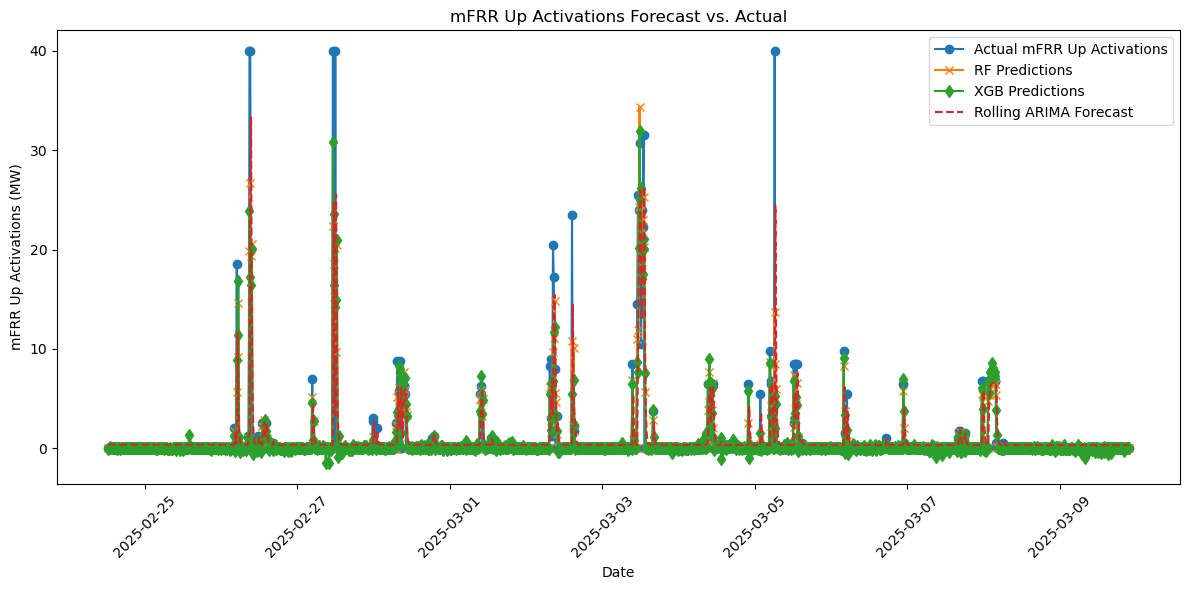

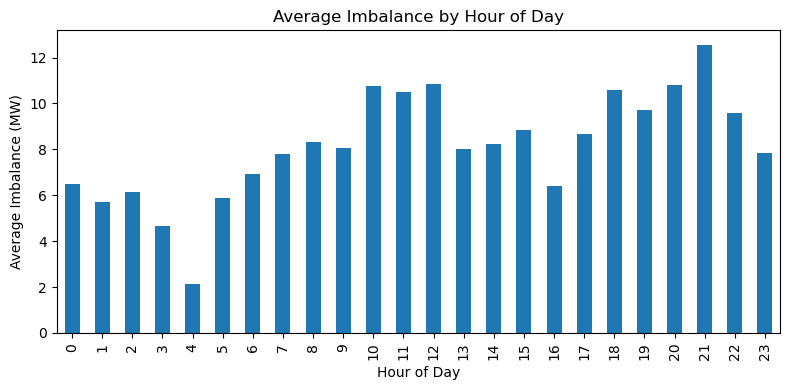

In [25]:
# ============================
# 10. Visualizations
# ============================
plt.figure(figsize=(12, 6))
plt.plot(test['date'], y_test_mfrr, label='Actual mFRR Up Activations', marker='o')
plt.plot(test['date'], rf_preds_mfrr, label='RF Predictions', marker='x')
plt.plot(test['date'], xgb_preds_mfrr, label='XGB Predictions', marker='d')
plt.plot(test['date'], arima_predictions, label='Rolling ARIMA Forecast', linestyle='--')
plt.xlabel("Date")
plt.ylabel("mFRR Up Activations (MW)")
plt.title("mFRR Up Activations Forecast vs. Actual")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Visualize hourly imbalance tendencies
data['hour'] = data['date'].dt.hour
imbalance_hourly = data.groupby('hour')[target_imbalance].mean()
plt.figure(figsize=(8, 4))
imbalance_hourly.plot(kind='bar')
plt.xlabel("Hour of Day")
plt.ylabel("Average Imbalance (MW)")
plt.title("Average Imbalance by Hour of Day")
plt.tight_layout()
plt.show()

In [26]:
# ============================
# 11. Summary Report
# ============================
print("\n=== Summary Report ===")
print("Imbalance Prediction:")
print("  - Random Forest RMSE: {:.2f}, MAE: {:.2f}".format(rf_rmse_imb, rf_mae_imb))
print("  - XGBoost RMSE: {:.2f}, MAE: {:.2f}".format(xgb_rmse_imb, xgb_mae_imb))
print("\nmFRR Up Activations Prediction:")
print("  - Random Forest RMSE: {:.2f}, MAE: {:.2f}".format(rf_rmse_mfrr, rf_mae_mfrr))
print("  - XGBoost RMSE: {:.2f}, MAE: {:.2f}".format(xgb_rmse_mfrr, xgb_mae_mfrr))
print("\nRolling ARIMA Forecast for mFRR Up Activations:")
print("  - RMSE: {:.2f}, MAE: {:.2f}".format(arima_rmse, arima_mae))
print("\nCorrelation between Imbalance and mFRR Up Activations: {:.2f}".format(corr))
print("Observation: Imbalance volumes show distinct hourly patterns—certain hours exhibit higher positive imbalances, "
      "likely linked to weather and market dynamics. The rolling ARIMA approach, which updates the forecast with actual "
      "values after each timestep, reflects a more realistic operational scenario.")


=== Summary Report ===
Imbalance Prediction:
  - Random Forest RMSE: 11.51, MAE: 6.79
  - XGBoost RMSE: 9.78, MAE: 6.05

mFRR Up Activations Prediction:
  - Random Forest RMSE: 2.20, MAE: 0.42
  - XGBoost RMSE: 2.47, MAE: 0.52

Rolling ARIMA Forecast for mFRR Up Activations:
  - RMSE: 3.42, MAE: 1.03

Correlation between Imbalance and mFRR Up Activations: -0.49
Observation: Imbalance volumes show distinct hourly patterns—certain hours exhibit higher positive imbalances, likely linked to weather and market dynamics. The rolling ARIMA approach, which updates the forecast with actual values after each timestep, reflects a more realistic operational scenario.
